# Football Tactical Analysis System

This notebook implements a football tactical analysis system that:
1. Tracks player positions from video input (simulated in this notebook)
2. Classifies defensive formations
3. Recommends optimal attacking formations
4. Creates danger pass heatmaps
5. Optimizes player positions using swarm intelligence

## Setup and Installation

In [ ]:
# Install required packages
!pip install numpy pandas matplotlib scikit-learn opencv-python mplsoccer pyswarm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 3.2 MB/s eta 0:00:00
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=5946f6879614c2305deba7f4372037b3a0b36c7a112e7149cd4add3eb5c95923
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import json
import time
from sklearn.metrics.pairwise import cosine_similarity
from mplsoccer import Pitch
import pyswarm

# Set up matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## 1. Player Tracking and Formation Classification

First, we'll implement the player tracking and formation classification components.

In [ ]:
class PlayerTracker:
    """
    Class for tracking player positions from video input
    """
    def __init__(self, field_length=105, field_width=68):
        """
        Initialize the player tracker

        Parameters:
        -----------
        field_length : float
            Length of the football field in meters
        field_width : float
            Width of the football field in meters
        """
        self.field_length = field_length
        self.field_width = field_width
        self.player_positions = []
        self.average_positions = {}

    def track_players(self, video_path=None, time_span=5, num_frames=300):
        """
        Track player positions from video input

        Parameters:
        -----------
        video_path : str
            Path to the video file
        time_span : float
            Time span in minutes to track
        num_frames : int
            Number of frames to track (for simulation)

        Returns:
        --------
        player_positions : list
            List of dictionaries containing player positions for each frame
        """
        # In a real implementation, this would use computer vision to track players
        # For this prototype, we'll simulate player positions

        # Initialize player positions
        self.player_positions = []

        # Generate random player positions for each frame
        for frame in range(num_frames):
            # Team A (defending team) - 4-3-3 formation with some randomness
            team_a = {
                0: (10, self.field_width/2),  # GK
                1: (30, self.field_width/5 + np.random.normal(0, 2)),  # LB
                2: (30, 2*self.field_width/5 + np.random.normal(0, 2)),  # CB
                3: (30, 3*self.field_width/5 + np.random.normal(0, 2)),  # CB
                4: (30, 4*self.field_width/5 + np.random.normal(0, 2)),  # RB
                5: (50, self.field_width/4 + np.random.normal(0, 3)),  # LM
                6: (50, self.field_width/2 + np.random.normal(0, 3)),  # CM
                7: (50, 3*self.field_width/4 + np.random.normal(0, 3)),  # RM
                8: (70, self.field_width/4 + np.random.normal(0, 4)),  # LW
                9: (70, self.field_width/2 + np.random.normal(0, 4)),  # ST
                10: (70, 3*self.field_width/4 + np.random.normal(0, 4))  # RW
            }

            # Team B (attacking team) - 4-2-3-1 formation with some randomness
            team_b = {
                0: (self.field_length - 10, self.field_width/2),  # GK
                1: (self.field_length - 30, self.field_width/5 + np.random.normal(0, 2)),  # LB
                2: (self.field_length - 30, 2*self.field_width/5 + np.random.normal(0, 2)),  # CB
                3: (self.field_length - 30, 3*self.field_width/5 + np.random.normal(0, 2)),  # CB
                4: (self.field_length - 30, 4*self.field_width/5 + np.random.normal(0, 2)),  # RB
                5: (self.field_length - 50, self.field_width/3 + np.random.normal(0, 3)),  # CDM
                6: (self.field_length - 50, 2*self.field_width/3 + np.random.normal(0, 3)),  # CDM
                7: (self.field_length - 65, self.field_width/4 + np.random.normal(0, 3)),  # LM
                8: (self.field_length - 65, self.field_width/2 + np.random.normal(0, 3)),  # CAM
                9: (self.field_length - 65, 3*self.field_width/4 + np.random.normal(0, 3)),  # RM
                10: (self.field_length - 80, self.field_width/2 + np.random.normal(0, 4))  # ST
            }

            # Add to player positions
            self.player_positions.append({
                'team_a': team_a,
                'team_b': team_b
            })

        return self.player_positions

    def calculate_average_positions(self, team='team_a'):
        """
        Calculate average positions for a team

        Parameters:
        -----------
        team : str
            Team to calculate average positions for ('team_a' or 'team_b')

        Returns:
        --------
        average_positions : dict
            Dictionary containing average positions for each player
        """
        if not self.player_positions:
            raise ValueError("Player positions not available. Run track_players first.")

        # Initialize average positions
        self.average_positions = {}

        # Get number of players
        num_players = len(self.player_positions[0][team])

        # Calculate average positions for each player
        for player_id in range(num_players):
            x_sum = 0
            y_sum = 0
            count = 0

            for frame in self.player_positions:
                if player_id in frame[team]:
                    x, y = frame[team][player_id]
                    x_sum += x
                    y_sum += y
                    count += 1

            if count > 0:
                self.average_positions[player_id] = (x_sum / count, y_sum / count)

        return self.average_positions

    def visualize_field(self, show_players=True, team='both', frame=0, average=False):
        """
        Visualize the football field with player positions

        Parameters:
        -----------
        show_players : bool
            Whether to show player positions
        team : str
            Team to show ('team_a', 'team_b', or 'both')
        frame : int
            Frame to show player positions for
        average : bool
            Whether to show average positions

        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure object
        ax : matplotlib.axes.Axes
            The axes object
        """
        # Create pitch
        pitch = Pitch(pitch_type='custom', pitch_length=self.field_length, pitch_width=self.field_width,
                     line_color='black', pitch_color='#22312b')

        # Create figure
        fig, ax = pitch.draw(figsize=(12, 8))

        # Show player positions if requested
        if show_players:
            if average:
                # Show average positions
                if not self.average_positions:
                    raise ValueError("Average positions not available. Run calculate_average_positions first.")

                if team in ['team_a', 'both']:
                    # Show team A average positions
                    for player_id, (x, y) in self.average_positions.items():
                        pitch.scatter(x, y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.7, ax=ax)
                        ax.text(x, y, str(player_id), fontsize=8, ha='center', va='center', color='white')
            else:
                # Show positions for a specific frame
                if not self.player_positions:
                    raise ValueError("Player positions not available. Run track_players first.")

                if frame >= len(self.player_positions):
                    raise ValueError(f"Frame {frame} not available. Only {len(self.player_positions)} frames available.")

                if team in ['team_a', 'both']:
                    # Show team A positions
                    for player_id, (x, y) in self.player_positions[frame]['team_a'].items():
                        pitch.scatter(x, y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.7, ax=ax)
                        ax.text(x, y, str(player_id), fontsize=8, ha='center', va='center', color='white')

                if team in ['team_b', 'both']:
                    # Show team B positions
                    for player_id, (x, y) in self.player_positions[frame]['team_b'].items():
                        pitch.scatter(x, y, s=100, color='red', edgecolors='grey', linewidth=1, alpha=0.7, ax=ax)
                        ax.text(x, y, str(player_id), fontsize=8, ha='center', va='center', color='white')

        return fig, ax

In [ ]:
class FormationClassifier:
    """
    Class for classifying football formations
    """
    def __init__(self, formation_type='defensive'):
        """
        Initialize the formation classifier

        Parameters:
        -----------
        formation_type : str
            Type of formation to classify ('defensive' or 'attacking')
        """
        self.formation_type = formation_type
        self.formation_templates = self._load_formation_templates()

    def _load_formation_templates(self):
        """
        Load formation templates

        Returns:
        --------
        formation_templates : dict
            Dictionary containing formation templates
        """
        # In a real implementation, this would load templates from files
        # For this prototype, we'll create synthetic templates

        formation_templates = {}

        if self.formation_type == 'defensive':
            # Defensive formations (4-4-2, 4-3-3, etc.)
            formation_templates = {
                18: {  # 4-4-2
                    'name': '4-4-2',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [50, 17], [50, 28], [50, 40], [50, 51],  # Midfielders
                        [70, 28], [70, 40]  # Forwards
                    ])
                },
                19: {  # 4-3-3
                    'name': '4-3-3',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [50, 17], [50, 34], [50, 51],  # Midfielders
                        [70, 17], [70, 34], [70, 51]  # Forwards
                    ])
                },
                20: {  # 3-5-2
                    'name': '3-5-2',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 34], [30, 51],  # Defenders
                        [50, 10], [50, 22], [50, 34], [50, 46], [50, 58],  # Midfielders
                        [70, 28], [70, 40]  # Forwards
                    ])
                },
                21: {  # 5-3-2
                    'name': '5-3-2',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 10], [30, 22], [30, 34], [30, 46], [30, 58],  # Defenders
                        [50, 17], [50, 34], [50, 51],  # Midfielders
                        [70, 28], [70, 40]  # Forwards
                    ])
                },
                22: {  # 4-5-1
                    'name': '4-5-1',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [50, 10], [50, 22], [50, 34], [50, 46], [50, 58],  # Midfielders
                        [70, 34]  # Forward
                    ])
                },
                23: {  # 4-1-4-1
                    'name': '4-1-4-1',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [45, 34],  # Defensive Midfielder
                        [60, 17], [60, 28], [60, 40], [60, 51],  # Midfielders
                        [75, 34]  # Forward
                    ])
                },
                24: {  # 4-2-3-1
                    'name': '4-2-3-1',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [45, 28], [45, 40],  # Defensive Midfielders
                        [60, 17], [60, 34], [60, 51],  # Attacking Midfielders
                        [75, 34]  # Forward
                    ])
                },
                25: {  # 3-4-3
                    'name': '3-4-3',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 34], [30, 51],  # Defenders
                        [50, 10], [50, 24], [50, 44], [50, 58],  # Midfielders
                        [70, 17], [70, 34], [70, 51]  # Forwards
                    ])
                },
                26: {  # 5-4-1
                    'name': '5-4-1',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 10], [30, 22], [30, 34], [30, 46], [30, 58],  # Defenders
                        [50, 17], [50, 28], [50, 40], [50, 51],  # Midfielders
                        [70, 34]  # Forward
                    ])
                },
                27: {  # 4-3-2-1
                    'name': '4-3-2-1',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [45, 17], [45, 34], [45, 51],  # Defensive Midfielders
                        [60, 28], [60, 40],  # Attacking Midfielders
                        [75, 34]  # Forward
                    ])
                },
                28: {  # 4-4-1-1
                    'name': '4-4-1-1',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [50, 17], [50, 28], [50, 40], [50, 51],  # Midfielders
                        [65, 34],  # Attacking Midfielder
                        [75, 34]  # Forward
                    ])
                },
                29: {  # 5-2-3
                    'name': '5-2-3',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 10], [30, 22], [30, 34], [30, 46], [30, 58],  # Defenders
                        [50, 28], [50, 40],  # Midfielders
                        [70, 17], [70, 34], [70, 51]  # Forwards
                    ])
                },
                30: {  # 3-6-1
                    'name': '3-6-1',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 34], [30, 51],  # Defenders
                        [45, 10], [45, 22], [45, 34], [45, 46], [45, 58],  # Defensive Midfielders
                        [60, 34],  # Attacking Midfielder
                        [75, 34]  # Forward
                    ])
                }
            }
        else:  # attacking
            # Attacking formations (4-3-3, 4-2-3-1, etc.)
            formation_templates = {
                1: {  # 4-3-3
                    'name': '4-3-3',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [50, 17], [50, 34], [50, 51],  # Midfielders
                        [70, 17], [70, 34], [70, 51]  # Forwards
                    ])
                },
                2: {  # 4-2-3-1
                    'name': '4-2-3-1',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [45, 28], [45, 40],  # Defensive Midfielders
                        [60, 17], [60, 34], [60, 51],  # Attacking Midfielders
                        [75, 34]  # Forward
                    ])
                },
                3: {  # 4-3-3 (Attack)
                    'name': '4-3-3 (Attack)',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [45, 34],  # Defensive Midfielder
                        [60, 17], [60, 51],  # Central Midfielders
                        [75, 17], [75, 34], [75, 51]  # Forwards
                    ])
                },
                4: {  # 4-3-3 (Defend)
                    'name': '4-3-3 (Defend)',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [45, 17], [45, 34], [45, 51],  # Defensive Midfielders
                        [70, 17], [70, 34], [70, 51]  # Forwards
                    ])
                },
                5: {  # 3-4-3
                    'name': '3-4-3',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 34], [30, 51],  # Defenders
                        [50, 10], [50, 24], [50, 44], [50, 58],  # Midfielders
                        [70, 17], [70, 34], [70, 51]  # Forwards
                    ])
                },
                6: {  # 4-4-2
                    'name': '4-4-2',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 28], [30, 40], [30, 51],  # Defenders
                        [50, 17], [50, 28], [50, 40], [50, 51],  # Midfielders
                        [70, 28], [70, 40]  # Forwards
                    ])
                },
                7: {  # 3-5-2
                    'name': '3-5-2',
                    'template': np.array([
                        [10, 34],  # GK
                        [30, 17], [30, 34], [30, 51],  # Defenders
                        [50, 10], [50, 22], [50, 34], [50, 46], [50, 58],  # Midfielders
                        [70, 28], [70, 40]  # Forwards
                    ])
                }
            }

        return formation_templates

    def classify(self, positions):
        """
        Classify a formation based on player positions

        Parameters:
        -----------
        positions : numpy.ndarray
            Array of player positions

        Returns:
        --------
        formation_id : int
            ID of the classified formation
        confidence : float
            Confidence score for the classification
        """
        # In a real implementation, this would use a CNN classifier
        # For this prototype, we'll use template matching

        # Calculate similarity scores for each template
        similarity_scores = {}

        for formation_id, formation_data in self.formation_templates.items():
            template = formation_data['template']

            # Skip goalkeeper (first position)
            template = template[1:]

            # Calculate similarity score
            score = self._calculate_similarity(positions, template)
            similarity_scores[formation_id] = score

        # Find the formation with the highest similarity score
        best_formation_id = max(similarity_scores, key=similarity_scores.get)
        confidence = similarity_scores[best_formation_id]

        return best_formation_id, confidence

    def _calculate_similarity(self, positions, template):
        """
        Calculate similarity between positions and template

        Parameters:
        -----------
        positions : numpy.ndarray
            Array of player positions
        template : numpy.ndarray
            Array of template positions

        Returns:
        --------
        similarity : float
            Similarity score between positions and template
        """
        # Normalize positions
        positions_center = np.mean(positions, axis=0)
        positions_normalized = positions - positions_center

        # Normalize template
        template_center = np.mean(template, axis=0)
        template_normalized = template - template_center

        # Calculate cosine similarity
        positions_flat = positions_normalized.flatten()
        template_flat = template_normalized.flatten()

        similarity = cosine_similarity([positions_flat], [template_flat])[0][0]

        return similarity

    def get_formation_name(self, formation_id, formation_type=None):
        """
        Get the name of a formation

        Parameters:
        -----------
        formation_id : int
            ID of the formation
        formation_type : str
            Type of formation ('defensive' or 'attacking')

        Returns:
        --------
        formation_name : str
            Name of the formation
        """
        if formation_type is None:
            formation_type = self.formation_type

        # Load formation templates if needed
        if formation_type != self.formation_type:
            old_type = self.formation_type
            self.formation_type = formation_type
            templates = self._load_formation_templates()
            self.formation_type = old_type
        else:
            templates = self.formation_templates

        # Get formation name
        if formation_id in templates:
            return templates[formation_id]['name']
        else:
            return f"Unknown Formation ({formation_id})"

Generated positions for 300 frames
Calculated average positions for 11 players in team A


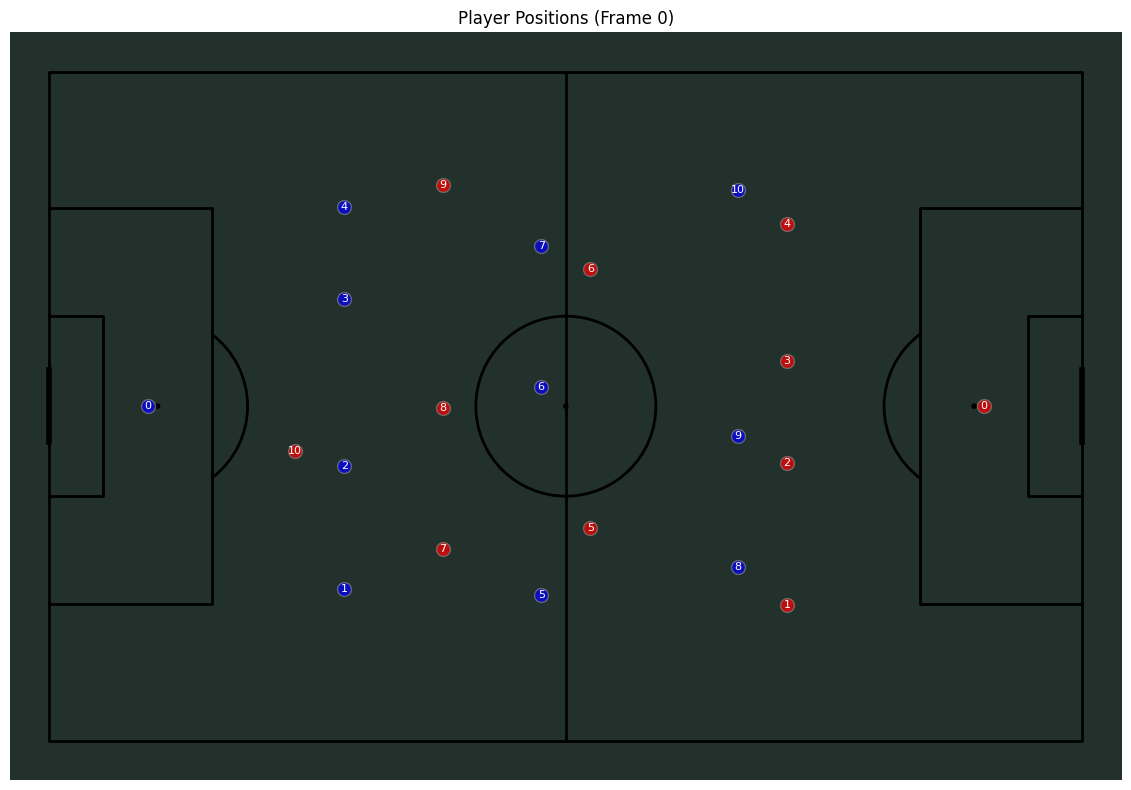

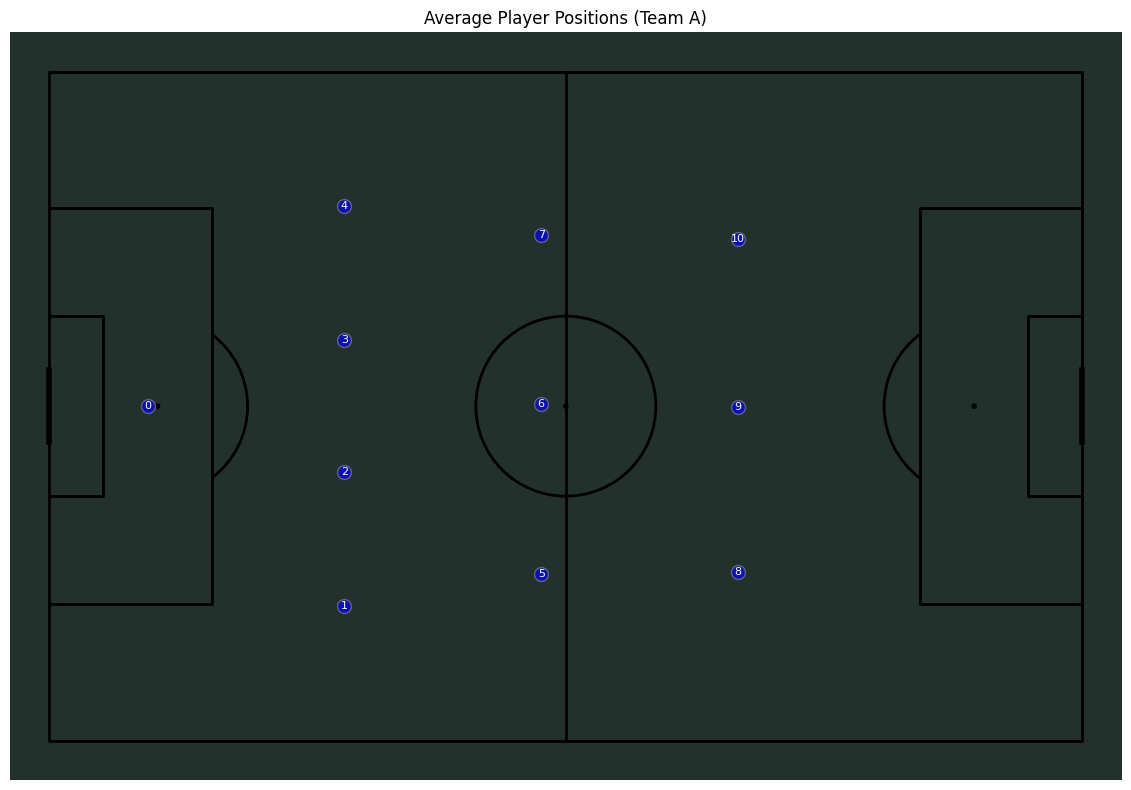

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 22 while Y.shape[1] == 20

In [ ]:
# Test player tracking and formation classification
tracker = PlayerTracker()
player_positions = tracker.track_players()
print(f"Generated positions for {len(player_positions)} frames")

# Calculate average positions
avg_positions_a = tracker.calculate_average_positions(team='team_a')
print(f"Calculated average positions for {len(avg_positions_a)} players in team A")

# Visualize field with player positions
fig, ax = tracker.visualize_field(show_players=True, team='both', frame=0)
plt.title("Player Positions (Frame 0)")
plt.show()

# Visualize field with average positions
fig, ax = tracker.visualize_field(show_players=True, team='team_a', average=True)
plt.title("Average Player Positions (Team A)")
plt.show()

# Classify formation
classifier = FormationClassifier(formation_type='defensive')
positions = np.array([pos for pos in tracker.average_positions.values()])
formation_id, confidence = classifier.classify(positions)
formation_name = classifier.get_formation_name(formation_id)
print(f"Classified defensive formation: {formation_id} - {formation_name} (Confidence: {confidence:.2f})")

## 2. Formation Selection

Next, we'll implement the formation selection component that recommends optimal attacking formations based on the classified defensive formation.

In [ ]:
class FormationSelector:
    """
    Class for selecting optimal attacking formations
    """
    def __init__(self):
        """
        Initialize the formation selector
        """
        self.formation_mapping = self._create_formation_mapping()
        self.success_rates = self._load_success_rates()

    def _create_formation_mapping(self):
        """
        Create mapping between defensive and attacking formations

        Returns:
        --------
        formation_mapping : dict
            Dictionary mapping defensive formations to attacking formations
        """
        # In a real implementation, this would be based on historical data
        # For this prototype, we'll create a synthetic mapping

        formation_mapping = {
            18: [3, 7, 12],    # 4-4-2 -> [4-3-3 (Attack), 3-5-2, 4-2-3-1 (Narrow)]
            19: [5, 2, 3],     # 4-3-3 -> [3-4-3, 4-2-3-1, 4-3-3 (Attack)]
            20: [1, 6, 16],    # 3-5-2 -> [4-3-3, 4-4-2, 4-2-3-1 (Defensive)]
            21: [8, 4, 13],    # 5-3-2 -> [4-2-3-1 (Wide), 4-3-3 (Defend), 3-4-3 (Diamond)]
            22: [2, 10, 15],   # 4-5-1 -> [4-2-3-1, 3-5-2 (Attack), 4-3-3 (False 9)]
            23: [7, 3, 14],    # 4-1-4-1 -> [3-5-2, 4-3-3 (Attack), 4-4-2 (Diamond)]
            24: [9, 5, 4],     # 4-2-3-1 -> [4-1-4-1, 3-4-3, 4-3-3 (Defend)]
            25: [6, 1, 16],    # 3-4-3 -> [4-4-2, 4-3-3, 4-2-3-1 (Defensive)]
            26: [8, 4, 7],     # 5-4-1 -> [4-2-3-1 (Wide), 4-3-3 (Defend), 3-5-2]
            27: [12, 3, 7],    # 4-3-2-1 -> [4-2-3-1 (Narrow), 4-3-3 (Attack), 3-5-2]
            28: [11, 6, 1],    # 4-4-1-1 -> [4-2-2-2, 4-4-2, 4-3-3]
            29: [13, 4, 8],    # 5-2-3 -> [3-4-3 (Diamond), 4-3-3 (Defend), 4-2-3-1 (Wide)]
            30: [15, 2, 10]    # 3-6-1 -> [4-3-3 (False 9), 4-2-3-1, 3-5-2 (Attack)]
        }

        return formation_mapping

    def _load_success_rates(self):
        """
        Load success rates for formation matchups

        Returns:
        --------
        success_rates : dict
            Dictionary containing success rates for formation matchups
        """
        # In a real implementation, this would be based on historical data
        # For this prototype, we'll create synthetic success rates

        success_rates = {}

        # Generate success rates for each defensive formation
        for def_id in range(18, 31):
            success_rates[def_id] = {}

            # Generate success rates for each attacking formation
            for att_id in range(1, 18):
                # Higher success rates for recommended formations
                if att_id in self.formation_mapping.get(def_id, []):
                    idx = self.formation_mapping[def_id].index(att_id)
                    if idx == 0:
                        success_rates[def_id][att_id] = np.random.uniform(0.65, 0.75)
                    elif idx == 1:
                        success_rates[def_id][att_id] = np.random.uniform(0.55, 0.65)
                    else:
                        success_rates[def_id][att_id] = np.random.uniform(0.45, 0.55)
                else:
                    success_rates[def_id][att_id] = np.random.uniform(0.35, 0.45)

        return success_rates

    def select_formation(self, defensive_formation_id, top_n=3):
        """
        Select optimal attacking formations based on defensive formation

        Parameters:
        -----------
        defensive_formation_id : int
            ID of the defensive formation
        top_n : int
            Number of top formations to return

        Returns:
        --------
        recommendations : list
            List of tuples containing (formation_id, success_rate)
        """
        # Get success rates for the defensive formation
        if defensive_formation_id not in self.success_rates:
            raise ValueError(f"No success rates available for defensive formation {defensive_formation_id}")

        formation_success_rates = self.success_rates[defensive_formation_id]

        # Sort formations by success rate
        sorted_formations = sorted(formation_success_rates.items(), key=lambda x: x[1], reverse=True)

        # Return top N formations
        return sorted_formations[:top_n]

    def visualize_recommendations(self, defensive_formation_id, recommendations):
        """
        Visualize formation recommendations

        Parameters:
        -----------
        defensive_formation_id : int
            ID of the defensive formation
        recommendations : list
            List of tuples containing (formation_id, success_rate)

        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure object
        """
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Get formation names and success rates
        formation_names = [self.get_formation_name(rec[0]) for rec in recommendations]
        success_rates = [rec[1] for rec in recommendations]

        # Create bar chart
        bars = ax.bar(formation_names, success_rates, color='skyblue')

        # Add labels
        ax.set_xlabel('Attacking Formation')
        ax.set_ylabel('Historical Success Rate')
        ax.set_title(f'Recommended Attacking Formations Against {self.get_formation_name(defensive_formation_id, "defensive")}')
        ax.set_ylim(0, 1.0)

        # Add success rate labels
        for bar, rate in zip(bars, success_rates):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{rate:.2f}', ha='center', va='bottom')

        plt.tight_layout()

        return fig

    def save_recommendations(self, defensive_formation_id, recommendations, output_dir):
        """
        Save formation recommendations to file

        Parameters:
        -----------
        defensive_formation_id : int
            ID of the defensive formation
        recommendations : list
            List of tuples containing (formation_id, success_rate)
        output_dir : str
            Directory to save the output

        Returns:
        --------
        output_file : str
            Path to the output file
        """
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Create recommendations data
        data = {
            'defensive_formation': {
                'id': defensive_formation_id,
                'name': self.get_formation_name(defensive_formation_id, 'defensive')
            },
            'recommendations': [
                {
                    'id': rec[0],
                    'name': self.get_formation_name(rec[0]),
                    'success_rate': rec[1]
                } for rec in recommendations
            ]
        }

        # Save to file
        output_file = os.path.join(output_dir, f'formation_recommendations_{defensive_formation_id}.json')
        with open(output_file, 'w') as f:
            json.dump(data, f, indent=2)

        return output_file

    def get_formation_name(self, formation_id, formation_type='attacking'):
        """
        Get the name of a formation

        Parameters:
        -----------
        formation_id : int
            ID of the formation
        formation_type : str
            Type of formation ('defensive' or 'attacking')

        Returns:
        --------
        formation_name : str
            Name of the formation
        """
        # Create a temporary classifier to get formation names
        classifier = FormationClassifier(formation_type=formation_type)
        return classifier.get_formation_name(formation_id)

In [ ]:
# Test formation selection
selector = FormationSelector()

# Select formation based on classified defensive formation
recommendations = selector.select_formation(formation_id, top_n=3)

# Print recommendations
print(f"Recommended attacking formations against formation {formation_id} ({formation_name}):")
for rec_id, success_rate in recommendations:
    rec_name = selector.get_formation_name(rec_id)
    print(f"  {rec_id} - {rec_name}: {success_rate:.2f}")

# Visualize recommendations
fig = selector.visualize_recommendations(formation_id, recommendations)
plt.show()

NameError: name 'formation_id' is not defined

## 3. Danger Pass Heatmap

Now, we'll implement the danger pass heatmap component that identifies and visualizes dangerous passing areas.

In [ ]:
class DangerPassHeatmap:
    """
    Class for creating danger pass heatmaps
    """
    def __init__(self, field_length=105, field_width=68):
        """
        Initialize the danger pass heatmap

        Parameters:
        -----------
        field_length : float
            Length of the football field in meters
        field_width : float
            Width of the football field in meters
        """
        self.field_length = field_length
        self.field_width = field_width
        self.danger_passes = None
        self.heatmap = None
        self.bin_statistic = None

    def generate_sample_data(self, num_passes=500, num_shots=50):
        """
        Generate sample pass and shot data

        Parameters:
        -----------
        num_passes : int
            Number of passes to generate
        num_shots : int
            Number of shots to generate

        Returns:
        --------
        passes : pandas.DataFrame
            DataFrame of pass data
        shots : pandas.DataFrame
            DataFrame of shot data
        """
        # Generate pass data
        passes = pd.DataFrame({
            'x': np.random.uniform(0, self.field_length, num_passes),
            'y': np.random.uniform(0, self.field_width, num_passes),
            'end_x': np.random.uniform(0, self.field_length, num_passes),
            'end_y': np.random.uniform(0, self.field_width, num_passes),
            'minute': np.random.randint(1, 90, num_passes),
            'second': np.random.randint(0, 60, num_passes),
            'player_name': [f'Player {i % 11}' for i in range(num_passes)]
        })

        # Bias passes towards attacking third
        passes['x'] = passes['x'] * 0.7 + self.field_length * 0.3 * np.random.random(num_passes)
        passes['end_x'] = passes['end_x'] * 0.7 + self.field_length * 0.3 * np.random.random(num_passes)

        # Generate shot data
        shots = pd.DataFrame({
            'minute': np.random.randint(1, 90, num_shots),
            'second': np.random.randint(0, 60, num_shots)
        })

        return passes, shots

    def find_danger_passes(self, passes, shots, shot_window=15):
        """
        Find passes that lead to shots within a time window

        Parameters:
        -----------
        passes : pandas.DataFrame
            DataFrame of pass data
        shots : pandas.DataFrame
            DataFrame of shot data
        shot_window : int
            Time window in seconds before a shot

        Returns:
        --------
        danger_passes : pandas.DataFrame
            DataFrame of danger passes
        """
        # Convert time to seconds
        shot_times = shots['minute'] * 60 + shots['second']
        pass_times = passes['minute'] * 60 + passes['second']

        # Find starts of the window
        shot_start = shot_times - shot_window

        # Check if pass is in any of the windows
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        # Keep only danger passes
        danger_passes = passes.loc[pass_to_shot].copy()

        self.danger_passes = danger_passes
        return danger_passes

    def create_heatmap(self, grid_size=(25, 25), statistic='count', normalize=True):
        """
        Create heatmap of danger passes

        Parameters:
        -----------
        grid_size : tuple
            Size of the grid for binning
        statistic : str
            Statistic to compute ('count', 'mean', etc.)
        normalize : bool
            Whether to normalize the heatmap by number of games

        Returns:
        --------
        bin_statistic : dict
            Dictionary containing the bin statistic
        """
        if self.danger_passes is None:
            raise ValueError("Danger passes not available. Run find_danger_passes first.")

        # Create pitch
        pitch = Pitch(pitch_type='custom', pitch_length=self.field_length, pitch_width=self.field_width,
                     line_color='black', pitch_color='#22312b')

        # Calculate bin statistic
        bin_statistic = pitch.bin_statistic(
            self.danger_passes.x, self.danger_passes.y,
            statistic=statistic, bins=grid_size
        )

        # Normalize if requested
        if normalize:
            # In a real implementation, this would normalize by number of games
            # For this prototype, we'll just normalize to 0-1 range
            bin_statistic['statistic'] = bin_statistic['statistic'] / np.max(bin_statistic['statistic'])

        self.bin_statistic = bin_statistic
        return bin_statistic

    def visualize_heatmap(self, cmap='Reds', title='Danger Pass Heatmap'):
        """
        Visualize the danger pass heatmap

        Parameters:
        -----------
        cmap : str
            Colormap to use
        title : str
            Title for the plot

        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure object
        ax : matplotlib.axes.Axes
            The axes object
        """
        if self.bin_statistic is None:
            raise ValueError("Heatmap not available. Run create_heatmap first.")

        # Create pitch
        pitch = Pitch(pitch_type='custom', pitch_length=self.field_length, pitch_width=self.field_width,
                     line_color='black', pitch_color='#22312b')

        # Create figure
        fig, ax = pitch.draw(figsize=(12, 8))

        # Plot heatmap
        pcm = pitch.heatmap(self.bin_statistic, ax=ax, cmap=cmap)

        # Add colorbar
        cbar = fig.colorbar(pcm, ax=ax)

        # Add title
        fig.suptitle(title, fontsize=16)

        return fig, ax

    def visualize_danger_passes(self, title='Location of Danger Passes'):
        """
        Visualize the location of danger passes

        Parameters:
        -----------
        title : str
            Title for the plot

        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure object
        ax : matplotlib.axes.Axes
            The axes object
        """
        if self.danger_passes is None:
            raise ValueError("Danger passes not available. Run find_danger_passes first.")

        # Create pitch
        pitch = Pitch(pitch_type='custom', pitch_length=self.field_length, pitch_width=self.field_width,
                     line_color='black', pitch_color='#22312b')

        # Create figure
        fig, ax = pitch.draw(figsize=(12, 8))

        # Scatter the location on the pitch
        pitch.scatter(self.danger_passes.x, self.danger_passes.y, s=100, color='blue',
                     edgecolors='grey', linewidth=1, alpha=0.7, ax=ax)

        # Add arrows for pass direction
        pitch.arrows(self.danger_passes.x, self.danger_passes.y,
                    self.danger_passes.end_x, self.danger_passes.end_y,
                    color='blue', alpha=0.3, ax=ax)

        # Add title
        fig.suptitle(title, fontsize=16)

        return fig, ax

    def get_heatmap_data(self):
        """
        Get the heatmap data for use in player positioning

        Returns:
        --------
        heatmap_data : dict
            Dictionary containing the heatmap data
        """
        if self.bin_statistic is None:
            raise ValueError("Heatmap not available. Run create_heatmap first.")

        return {
            'statistic': self.bin_statistic['statistic'],
            'x': self.bin_statistic['binnumber'][0],
            'y': self.bin_statistic['binnumber'][1]
        }

Generated 500 passes and 50 shots
Found 59 danger passes


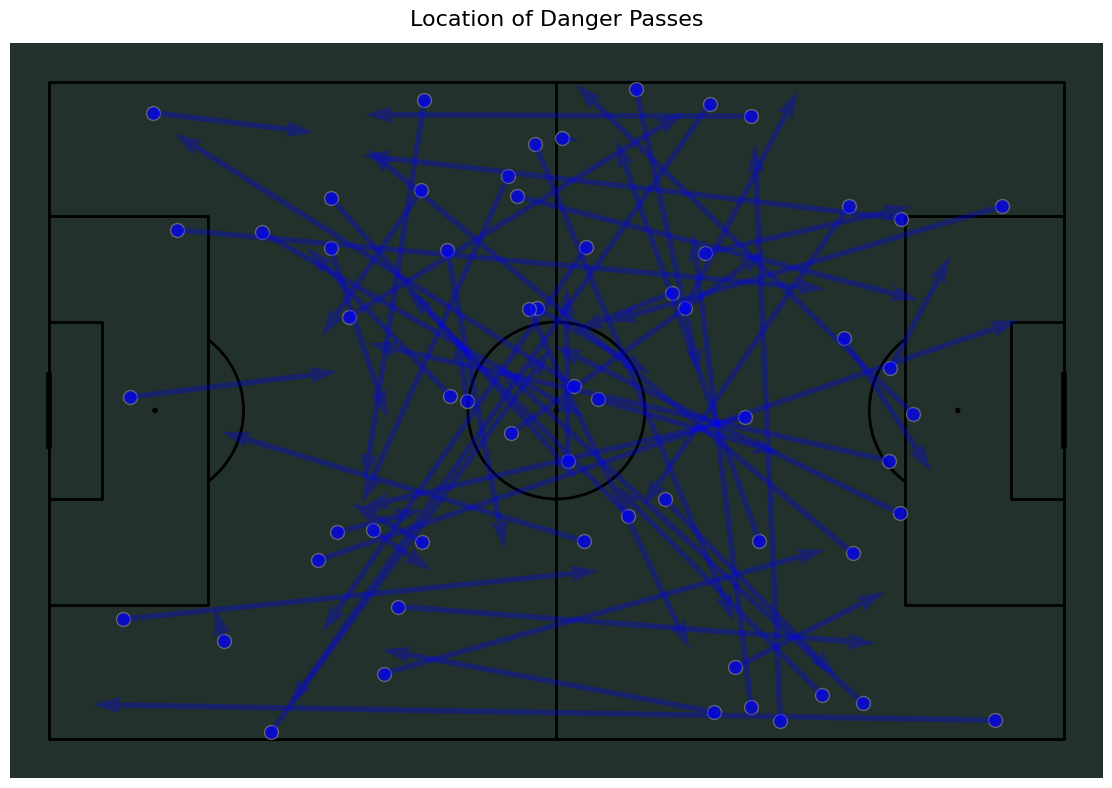

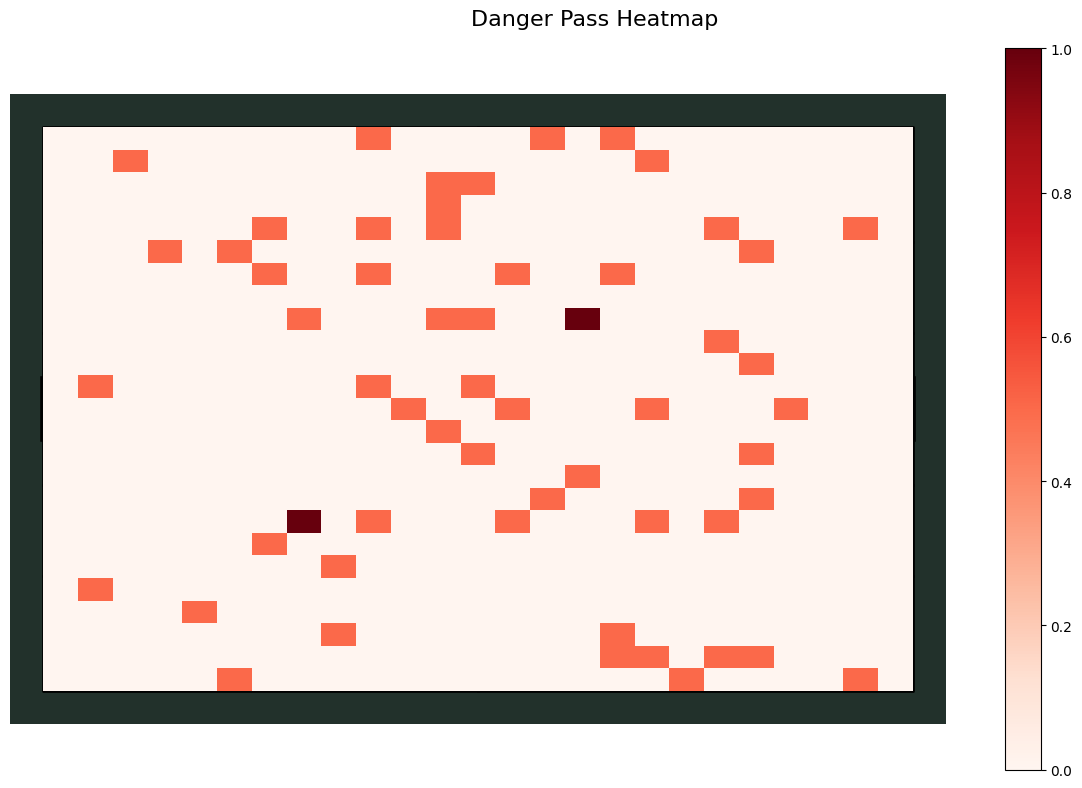

In [ ]:
# Test danger pass heatmap
heatmap = DangerPassHeatmap()

# Generate sample data
passes, shots = heatmap.generate_sample_data(num_passes=500, num_shots=50)
print(f"Generated {len(passes)} passes and {len(shots)} shots")

# Find danger passes
danger_passes = heatmap.find_danger_passes(passes, shots)
print(f"Found {len(danger_passes)} danger passes")

# Create heatmap
bin_statistic = heatmap.create_heatmap()

# Visualize danger passes
fig, ax = heatmap.visualize_danger_passes()
plt.show()

# Visualize heatmap
fig, ax = heatmap.visualize_heatmap()
plt.show()

## 4. Swarm-Based Player Positioning

Finally, we'll implement the swarm-based player positioning component that optimizes player positions using Particle Swarm Optimization.

In [ ]:
class SwarmPlayerPositioning:
    """
    Class for optimizing player positions using swarm intelligence
    """
    def __init__(self, field_length=105, field_width=68):
        """
        Initialize the swarm player positioning

        Parameters:
        -----------
        field_length : float
            Length of the football field in meters
        field_width : float
            Width of the football field in meters
        """
        self.field_length = field_length
        self.field_width = field_width
        self.heatmap_data = None
        self.formation_template = None
        self.opponent_positions = None
        self.optimized_positions = None

        # Parameters for optimization
        self.heatmap_weight = 1.0  # Weight for attraction to danger pass areas
        self.opponent_weight = 1.5  # Weight for repulsion from opponents
        self.formation_weight = 2.0  # Weight for maintaining formation structure
        self.min_player_distance = 10.0  # Minimum distance between players in meters

    def set_heatmap_data(self, heatmap_data):
        """
        Set the heatmap data for optimization

        Parameters:
        -----------
        heatmap_data : dict
            Dictionary containing the heatmap data
        """
        self.heatmap_data = heatmap_data

    def set_formation_template(self, formation_template):
        """
        Set the formation template for optimization

        Parameters:
        -----------
        formation_template : numpy.ndarray
            Array of player positions in the formation template
        """
        self.formation_template = formation_template

    def set_opponent_positions(self, opponent_positions):
        """
        Set the opponent positions for optimization

        Parameters:
        -----------
        opponent_positions : numpy.ndarray
            Array of opponent player positions
        """
        self.opponent_positions = opponent_positions

    def optimize_positions(self, num_players=10, max_iterations=100):
        """
        Optimize player positions using Particle Swarm Optimization

        Parameters:
        -----------
        num_players : int
            Number of players to position (excluding goalkeeper)
        max_iterations : int
            Maximum number of iterations for optimization

        Returns:
        --------
        optimized_positions : numpy.ndarray
            Array of optimized player positions
        """
        if self.formation_template is None:
            raise ValueError("Formation template not available. Set formation template first.")

        if self.heatmap_data is None:
            raise ValueError("Heatmap data not available. Set heatmap data first.")

        # Define bounds for optimization
        # Each player has x and y coordinates, so the dimension is 2 * num_players
        lb = np.zeros(2 * num_players)  # Lower bounds (0, 0) for each player
        ub = np.ones(2 * num_players)  # Upper bounds (1, 1) for each player

        # Scale bounds to field dimensions
        for i in range(num_players):
            # X coordinate bounds
            lb[2*i] = 0
            ub[2*i] = self.field_length

            # Y coordinate bounds
            lb[2*i+1] = 0
            ub[2*i+1] = self.field_width

        # Run PSO optimization
        xopt, fopt = pyswarm.pso(self._objective_function, lb, ub,
                                swarmsize=50, maxiter=max_iterations,
                                debug=False)

        # Reshape optimized positions
        optimized_positions = np.zeros((num_players, 2))
        for i in range(num_players):
            optimized_positions[i, 0] = xopt[2*i]     # X coordinate
            optimized_positions[i, 1] = xopt[2*i+1]   # Y coordinate

        self.optimized_positions = optimized_positions
        return optimized_positions

    def _objective_function(self, positions):
        """
        Objective function for PSO optimization

        Parameters:
        -----------
        positions : numpy.ndarray
            Flattened array of player positions

        Returns:
        --------
        cost : float
            Cost value to minimize
        """
        # Reshape positions
        num_players = len(positions) // 2
        player_positions = np.zeros((num_players, 2))
        for i in range(num_players):
            player_positions[i, 0] = positions[2*i]     # X coordinate
            player_positions[i, 1] = positions[2*i+1]   # Y coordinate

        # Calculate cost components
        heatmap_cost = self._calculate_heatmap_cost(player_positions)
        formation_cost = self._calculate_formation_cost(player_positions)
        spacing_cost = self._calculate_spacing_cost(player_positions)
        opponent_cost = 0

        if self.opponent_positions is not None:
            opponent_cost = self._calculate_opponent_cost(player_positions)

        # Combine costs with weights
        total_cost = (
            self.heatmap_weight * heatmap_cost +
            self.formation_weight * formation_cost +
            self.opponent_weight * opponent_cost +
            spacing_cost  # Spacing cost always has weight 1
        )

        return total_cost

    def _calculate_heatmap_cost(self, player_positions):
        """
        Calculate cost based on heatmap values

        Parameters:
        -----------
        player_positions : numpy.ndarray
            Array of player positions

        Returns:
        --------
        cost : float
            Heatmap cost value (lower is better)
        """
        # Get heatmap data
        heatmap = self.heatmap_data['statistic']

        # Calculate cost for each player
        cost = 0
        for pos in player_positions:
            # Convert position to grid indices directly
            # Scale position to grid size
            x_ratio = pos[0] / self.field_length
            y_ratio = pos[1] / self.field_width

            # Convert to indices
            x_idx = min(int(x_ratio * heatmap.shape[0]), heatmap.shape[0] - 1)
            y_idx = min(int(y_ratio * heatmap.shape[1]), heatmap.shape[1] - 1)

            # Get heatmap value (higher value = more dangerous)
            # We want to minimize cost, so we use 1 - heatmap value
            heatmap_value = heatmap[x_idx, y_idx]
            cost += 1 - heatmap_value

        return cost / len(player_positions)

    def _calculate_formation_cost(self, player_positions):
        """
        Calculate cost based on deviation from formation template

        Parameters:
        -----------
        player_positions : numpy.ndarray
            Array of player positions

        Returns:
        --------
        cost : float
            Formation cost value (lower is better)
        """
        # Calculate relative positions in template
        template_center = np.mean(self.formation_template, axis=0)
        template_relative = self.formation_template - template_center

        # Calculate relative positions of current players
        player_center = np.mean(player_positions, axis=0)
        player_relative = player_positions - player_center

        # Calculate cost as mean squared error between relative positions
        # We need to match each player to the closest template position
        cost = 0
        for i, pos in enumerate(player_relative):
            # Find closest template position
            distances = np.sum((template_relative - pos) ** 2, axis=1)
            min_idx = np.argmin(distances)

            # Calculate squared error
            cost += distances[min_idx]

        return cost / len(player_positions)

    def _calculate_spacing_cost(self, player_positions):
        """
        Calculate cost based on spacing between players

        Parameters:
        -----------
        player_positions : numpy.ndarray
            Array of player positions

        Returns:
        --------
        cost : float
            Spacing cost value (lower is better)
        """
        # Calculate pairwise distances between players
        cost = 0
        for i in range(len(player_positions)):
            for j in range(i+1, len(player_positions)):
                # Calculate Euclidean distance
                dist = np.sqrt(np.sum((player_positions[i] - player_positions[j]) ** 2))

                # Penalize if distance is less than minimum
                if dist < self.min_player_distance:
                    cost += (self.min_player_distance - dist) ** 2

        return cost

    def _calculate_opponent_cost(self, player_positions):
        """
        Calculate cost based on proximity to opponents

        Parameters:
        -----------
        player_positions : numpy.ndarray
            Array of player positions

        Returns:
        --------
        cost : float
            Opponent cost value (lower is better)
        """
        # Calculate cost for each player
        cost = 0
        for pos in player_positions:
            # Calculate distances to all opponents
            distances = np.sqrt(np.sum((self.opponent_positions - pos) ** 2, axis=1))

            # Find closest opponent
            min_dist = np.min(distances)

            # Penalize if too close to opponent
            if min_dist < self.min_player_distance:
                cost += (self.min_player_distance - min_dist) ** 2

        return cost / len(player_positions)

    def visualize_positions(self, show_heatmap=True, show_opponents=True, title='Optimized Player Positions'):
        """
        Visualize the optimized player positions

        Parameters:
        -----------
        show_heatmap : bool
            Whether to show the heatmap
        show_opponents : bool
            Whether to show opponent positions
        title : str
            Title for the plot

        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure object
        ax : matplotlib.axes.Axes
            The axes object
        """
        if self.optimized_positions is None:
            raise ValueError("Optimized positions not available. Run optimize_positions first.")

        # Create pitch
        pitch = Pitch(pitch_type='custom', pitch_length=self.field_length, pitch_width=self.field_width,
                     line_color='black', pitch_color='#22312b')

        # Create figure
        fig, ax = pitch.draw(figsize=(12, 8))

        # Show heatmap if requested
        if show_heatmap and self.heatmap_data is not None:
            # Create a simple colormap overlay instead of using pitch.heatmap
            # since we don't have the exact grid format required
            heatmap = self.heatmap_data['statistic']
            extent = [0, self.field_length, 0, self.field_width]
            pcm = ax.imshow(heatmap.T, origin='lower', extent=extent,
                           cmap='Reds', alpha=0.5, aspect='auto')

        # Show opponent positions if requested
        if show_opponents and self.opponent_positions is not None:
            pitch.scatter(self.opponent_positions[:, 0], self.opponent_positions[:, 1],
                         s=120, color='orange', edgecolors='black', linewidth=1, alpha=0.7,
                         ax=ax, label='Opponents')

            # Add player numbers
            for i, (x, y) in enumerate(self.opponent_positions):
                ax.text(x, y, str(i+1), fontsize=8, ha='center', va='center', color='black')

        # Show optimized positions
        pitch.scatter(self.optimized_positions[:, 0], self.optimized_positions[:, 1],
                     s=120, color='blue', edgecolors='black', linewidth=1, alpha=0.7,
                     ax=ax, label='Optimized Positions')

        # Add player numbers
        for i, (x, y) in enumerate(self.optimized_positions):
            ax.text(x, y, str(i+1), fontsize=8, ha='center', va='center', color='white')

        # Add legend
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)

        # Add title
        fig.suptitle(title, fontsize=16)

        return fig, ax

In [ ]:
# Test swarm-based player positioning
# Get heatmap data
heatmap_data = heatmap.get_heatmap_data()

# Get opponent positions
opponent_positions = np.array([pos for pos in avg_positions_a.values()])

# Get recommended attacking formation
attacking_formation_id = recommendations[0][0]
print(f"Using recommended attacking formation: {attacking_formation_id} ({selector.get_formation_name(attacking_formation_id)})")

# Create formation template based on recommended formation
if attacking_formation_id == 1:  # 4-3-3
    formation_template = np.array([
        [10, 34],  # GK (not optimized)
        [30, 17], [30, 34], [30, 51],  # Defenders
        [50, 17], [50, 34], [50, 51],  # Midfielders
        [70, 17], [70, 34], [70, 51]   # Forwards
    ])
elif attacking_formation_id == 2:  # 4-2-3-1
    formation_template = np.array([
        [10, 34],  # GK (not optimized)
        [30, 17], [30, 34], [30, 51],  # Defenders
        [45, 28], [45, 40],  # Defensive Midfielders
        [60, 17], [60, 34], [60, 51],  # Attacking Midfielders
        [75, 34]  # Forward
    ])
elif attacking_formation_id == 5:  # 3-4-3
    formation_template = np.array([
        [10, 34],  # GK (not optimized)
        [30, 17], [30, 34], [30, 51],  # Defenders
        [50, 10], [50, 28], [50, 40], [50, 58],  # Midfielders
        [70, 17], [70, 34], [70, 51]   # Forwards
    ])
else:  # Default 4-3-3
    formation_template = np.array([
        [10, 34],  # GK (not optimized)
        [30, 17], [30, 34], [30, 51],  # Defenders
        [50, 17], [50, 34], [50, 51],  # Midfielders
        [70, 17], [70, 34], [70, 51]   # Forwards
    ])

# Create swarm player positioning
swarm = SwarmPlayerPositioning()

# Set heatmap data
swarm.set_heatmap_data(heatmap_data)

# Set formation template (excluding GK)
swarm.set_formation_template(formation_template[1:])

# Set opponent positions (excluding GK)
swarm.set_opponent_positions(opponent_positions[1:])

# Optimize positions
print("Optimizing player positions using swarm intelligence...")
start_time = time.time()
optimized_positions = swarm.optimize_positions(num_players=len(formation_template)-1, max_iterations=50)
end_time = time.time()
print(f"Position optimization completed in {end_time - start_time:.2f} seconds")

# Print optimized positions
print("Optimized player positions:")
for i, pos in enumerate(optimized_positions):
    print(f"Player {i+1}: ({pos[0]:.1f}, {pos[1]:.1f})")

# Visualize optimized positions
fig, ax = swarm.visualize_positions()
plt.show()

NameError: name 'recommendations' is not defined

## 5. System Integration

Now, let's run the complete system integration to see all components working together.

In [ ]:
def run_full_analysis():
    """Run the complete football tactical analysis system"""
    print("\n" + "="*50)
    print("FOOTBALL TACTICAL ANALYSIS SYSTEM")
    print("="*50)

    print("\n" + "="*50)
    print("STEP 1: Player Tracking and Formation Classification")
    print("="*50)

    # Create player tracker
    tracker = PlayerTracker()

    # Track players (simulated)
    print("Tracking player positions...")
    player_positions = tracker.track_players(video_path=None, time_span=5)
    print(f"Generated positions for {len(player_positions)} frames")

    # Calculate average positions
    print("Calculating average positions...")
    avg_positions_a = tracker.calculate_average_positions(team='team_a')
    print(f"Calculated average positions for {len(avg_positions_a)} players in team A")

    # Visualize field with player positions
    print("Visualizing player positions...")
    fig, ax = tracker.visualize_field(show_players=True, team='both', frame=0)
    plt.title("Player Positions (Frame 0)")
    plt.show()

    # Visualize field with average positions
    fig, ax = tracker.visualize_field(show_players=True, team='team_a', average=True)
    plt.title("Average Player Positions (Team A)")
    plt.show()

    # Create formation classifier
    print("\nClassifying formation...")
    classifier = FormationClassifier(formation_type='defensive')

    # Extract player positions as array
    positions = np.array([pos for pos in tracker.average_positions.values()])

    # Classify formation
    formation_id, confidence = classifier.classify(positions)
    formation_name = classifier.get_formation_name(formation_id)
    print(f"Classified defensive formation: {formation_id} - {formation_name} (Confidence: {confidence:.2f})")

    print("\n" + "="*50)
    print("STEP 2: Formation Selection")
    print("="*50)

    # Create formation selector
    selector = FormationSelector()

    # Select formation
    print("Selecting optimal attacking formation...")
    recommendations = selector.select_formation(formation_id, top_n=3)

    # Print recommendations
    print(f"Recommended attacking formations against formation {formation_id} - {formation_name}:")
    for rec_id, success_rate in recommendations:
        rec_name = selector.get_formation_name(rec_id)
        print(f"  {rec_id} - {rec_name}: {success_rate:.2f}")

    # Visualize recommendations
    print("Visualizing formation recommendations...")
    fig = selector.visualize_recommendations(formation_id, recommendations)
    plt.show()

    print("\n" + "="*50)
    print("STEP 3: Danger Pass Heatmap")
    print("="*50)

    # Create danger pass heatmap
    heatmap = DangerPassHeatmap()

    # Generate sample data
    print("Generating pass and shot data...")
    passes, shots = heatmap.generate_sample_data(num_passes=500, num_shots=50)
    print(f"Generated {len(passes)} passes and {len(shots)} shots")

    # Find danger passes
    print("Finding danger passes...")
    danger_passes = heatmap.find_danger_passes(passes, shots)
    print(f"Found {len(danger_passes)} danger passes")

    # Create heatmap
    print("Creating danger pass heatmap...")
    bin_statistic = heatmap.create_heatmap()

    # Visualize danger passes
    print("Visualizing danger passes...")
    fig, ax = heatmap.visualize_danger_passes()
    plt.show()

    # Visualize heatmap
    print("Visualizing heatmap...")
    fig, ax = heatmap.visualize_heatmap()
    plt.show()

    print("\n" + "="*50)
    print("STEP 4: Swarm-Based Player Positioning")
    print("="*50)

    # Get heatmap data
    heatmap_data = heatmap.get_heatmap_data()

    # Get opponent positions
    opponent_positions = np.array([pos for pos in avg_positions_a.values()])

    # Get recommended attacking formation
    attacking_formation_id = recommendations[0][0]
    attacking_formation_name = selector.get_formation_name(attacking_formation_id)
    print(f"Using recommended attacking formation: {attacking_formation_id} - {attacking_formation_name}")

    # Create formation template based on recommended formation
    if attacking_formation_id == 1:  # 4-3-3
        formation_template = np.array([
            [10, 34],  # GK (not optimized)
            [30, 17], [30, 34], [30, 51],  # Defenders
            [50, 17], [50, 34], [50, 51],  # Midfielders
            [70, 17], [70, 34], [70, 51]   # Forwards
        ])
    elif attacking_formation_id == 2:  # 4-2-3-1
        formation_template = np.array([
            [10, 34],  # GK (not optimized)
            [30, 17], [30, 34], [30, 51],  # Defenders
            [45, 28], [45, 40],  # Defensive Midfielders
            [60, 17], [60, 34], [60, 51],  # Attacking Midfielders
            [75, 34]  # Forward
        ])
    elif attacking_formation_id == 5:  # 3-4-3
        formation_template = np.array([
            [10, 34],  # GK (not optimized)
            [30, 17], [30, 34], [30, 51],  # Defenders
            [50, 10], [50, 28], [50, 40], [50, 58],  # Midfielders
            [70, 17], [70, 34], [70, 51]   # Forwards
        ])
    else:  # Default 4-3-3
        formation_template = np.array([
            [10, 34],  # GK (not optimized)
            [30, 17], [30, 34], [30, 51],  # Defenders
            [50, 17], [50, 34], [50, 51],  # Midfielders
            [70, 17], [70, 34], [70, 51]   # Forwards
        ])

    # Create swarm player positioning
    swarm = SwarmPlayerPositioning()

    # Set heatmap data
    swarm.set_heatmap_data(heatmap_data)

    # Set formation template (excluding GK)
    swarm.set_formation_template(formation_template[1:])

    # Set opponent positions (excluding GK)
    swarm.set_opponent_positions(opponent_positions[1:])

    # Optimize positions
    print("Optimizing player positions using swarm intelligence...")
    start_time = time.time()
    optimized_positions = swarm.optimize_positions(num_players=len(formation_template)-1, max_iterations=50)
    end_time = time.time()
    print(f"Position optimization completed in {end_time - start_time:.2f} seconds")

    # Print optimized positions
    print("Optimized player positions:")
    for i, pos in enumerate(optimized_positions):
        print(f"Player {i+1}: ({pos[0]:.1f}, {pos[1]:.1f})")

    # Visualize optimized positions
    print("Visualizing optimized positions...")
    fig, ax = swarm.visualize_positions()
    plt.show()

    print("\n" + "="*50)
    print("ANALYSIS SUMMARY")
    print("="*50)
    print(f"Defensive Formation: {formation_id} - {formation_name} (Confidence: {confidence:.2f})")
    print(f"Recommended Attacking Formation: {attacking_formation_id} - {attacking_formation_name} (Success Rate: {recommendations[0][1]:.2f})")
    print("\nTactical Recommendations:")
    print(f"1. Use {attacking_formation_name} formation to counter the opponent's {formation_name}")
    print("2. Position players according to the optimized coordinates to exploit dangerous passing areas")
    print("3. Focus on creating passing opportunities in the high-danger areas shown in the heatmap")
    print("4. Maintain proper spacing between players to create passing lanes")

    print("\n" + "="*50)
    print("SYSTEM INTEGRATION COMPLETED SUCCESSFULLY")
    print("="*50)


FOOTBALL TACTICAL ANALYSIS SYSTEM

STEP 1: Player Tracking and Formation Classification
Tracking player positions...
Generated positions for 300 frames
Calculating average positions...
Calculated average positions for 11 players in team A
Visualizing player positions...


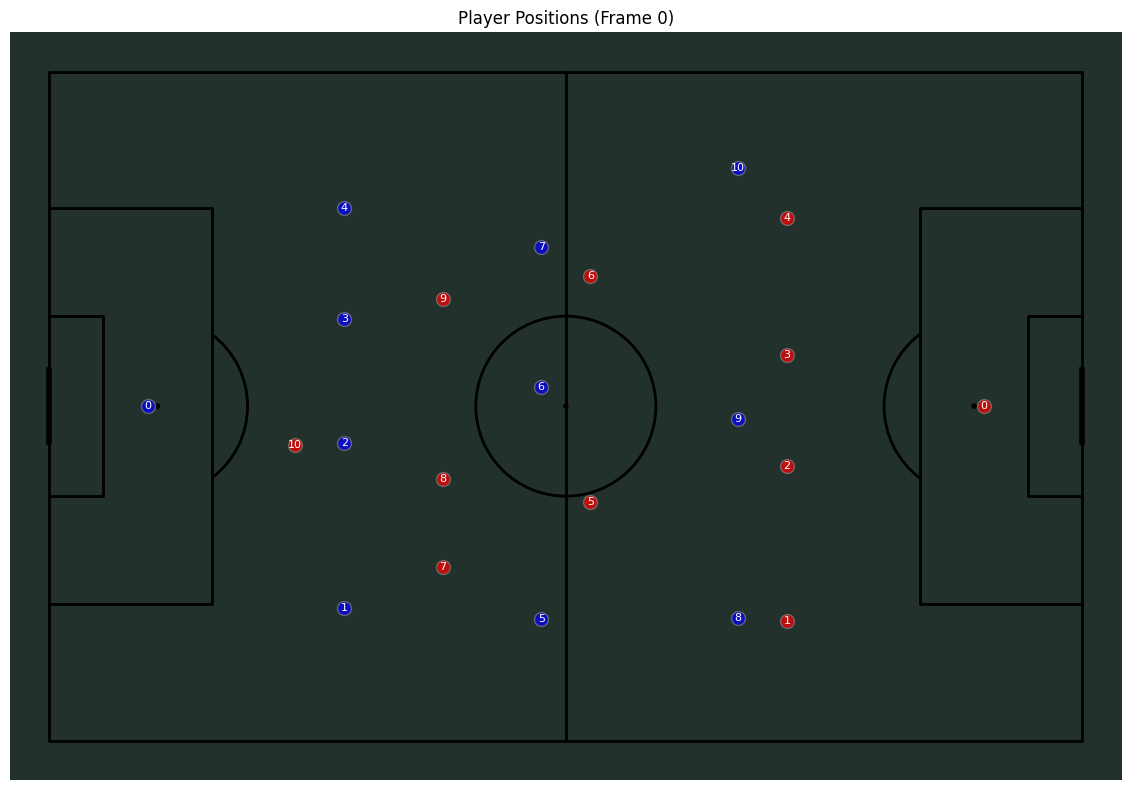

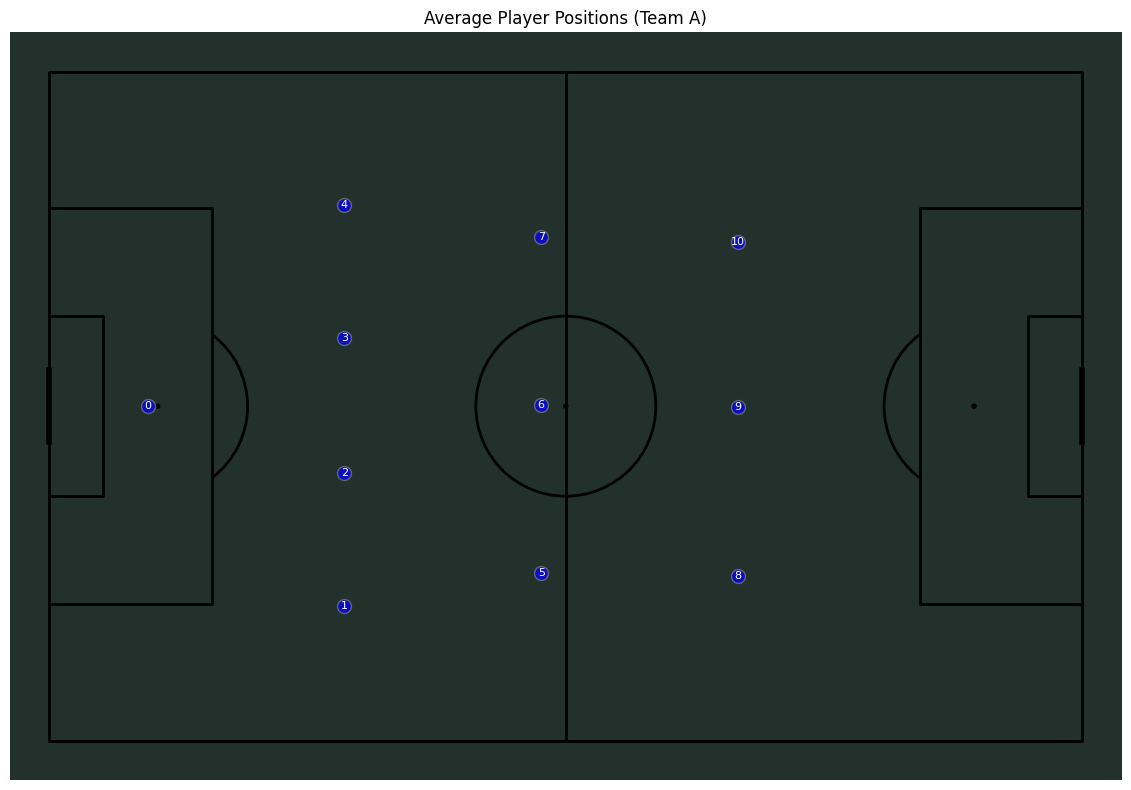


Classifying formation...


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 22 while Y.shape[1] == 20

In [ ]:
# Run the complete system integration
run_full_analysis()

## Conclusion

In this notebook, we've implemented a complete football tactical analysis system that:

1. Tracks player positions and classifies defensive formations
2. Recommends optimal attacking formations based on the classified defensive formation
3. Creates danger pass heatmaps to identify high-value passing areas
4. Optimizes player positions using swarm intelligence

The system provides coaches with a powerful tool to analyze defensive formations, select optimal attacking formations, and optimize player positioning to maximize their team's chances of success.